<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline". Do not forget about our shared ["primitive" baseline](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_english/topic04_linear_models/kaggle_medium_ridge_baseline.ipynb) - you'll find something valuable there.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
import pickle
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [175]:
PATH_TO_DATA = '../../../mlco_data/medium'

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [176]:
train_tags = pd.read_table(os.path.join(PATH_TO_DATA,'train_tags.txt'), sep='\n', header=None).applymap(lambda x: eval(x))
test_tags = pd.read_table(os.path.join(PATH_TO_DATA,'test_tags.txt'), sep='\n', header=None).applymap(lambda x: eval(x))
train_tags.shape, test_tags.shape

((62313, 1), (34645, 1))

In [177]:
train_tags['read_time'] = train_tags.iloc[:, 0].apply(lambda x: x.get('twitter:data1'))
test_tags['read_time'] = test_tags.iloc[:, 0].apply(lambda x: x.get('twitter:data1'))

In [178]:
len(train_tags['read_time'].value_counts())

112

In [179]:
encoder = LabelBinarizer(sparse_output=True)
X_train_time = encoder.fit_transform(train_tags['read_time'])
X_test_time = encoder.transform(test_tags['read_time'])

In [180]:
X_train_time.shape, X_test_time.shape

((62313, 112), (34645, 112))

In [262]:
import gc
gc.collect()

2845

In [263]:
chunks=pd.read_table(os.path.join(PATH_TO_DATA,'train_html.txt'), sep='\n', header=None, chunksize=1000)

In [264]:
%%time
train_html = pd.DataFrame()
train_html = pd.concat(chunk for chunk in chunks)

CPU times: user 20.6 s, sys: 1.28 s, total: 21.9 s
Wall time: 21.9 s


In [265]:
chunks = pd.read_table(os.path.join(PATH_TO_DATA,'test_html.txt'), sep='\n', header=None, chunksize=1000)

In [266]:
test_html = pd.DataFrame()
test_html = pd.concat(chunk for chunk in chunks)

In [267]:
train_html.shape, test_html.shape

((62313, 1), (34645, 1))

In [268]:
train_html['num_pics'] = train_html.applymap(lambda x: x.count('<img src'))
test_html['num_pics'] = test_html.applymap(lambda x: x.count('<img src'))

In [269]:
train_html['num_pics_log'] = train_html['num_pics'].apply(lambda x: np.log(x))
test_html['num_pics_log'] = test_html['num_pics'].apply(lambda x: np.log(x))

scaler.fit(train_html['num_pics_log'].values.reshape(-1,1))

train_html['num_pics_log_scaled'] = scaler.transform(train_html['num_pics_log'].values.reshape(-1,1))
test_html['num_pics_log_scaled'] = scaler.transform(test_html['num_pics_log'].values.reshape(-1,1))

In [270]:
train_html.head()

,0,num_pics,num_pics_log
0,"<div><header class=""container u-maxWidth740""><...",3,1.098612
1,"<div><header class=""container u-maxWidth740""><...",3,1.098612
2,"<div><header class=""container u-maxWidth740""><...",2,0.693147
3,"<div><header class=""container u-maxWidth740""><...",3,1.098612
4,"<div><header class=""container u-maxWidth740""><...",3,1.098612


In [271]:
scaler = StandardScaler()
scaler.fit(train_html['num_pics_log'].values.reshape(-1,1))

train_html['num_pics_log_scaled'] = scaler.transform(train_html['num_pics_log'].values.reshape(-1,1))
test_html['num_pics_log_scaled'] = scaler.transform(test_html['num_pics_log'].values.reshape(-1,1))

In [272]:
train_html['num_links'] = train_html[[0]].applymap(lambda x: x.count('<a href'))
test_html['num_links'] = test_html[[0]].applymap(lambda x: x.count('<a href'))

In [273]:
train_html['num_links_bins'] = pd.cut(train_html['num_links'], bins=(2,4,7,10,14,22, 1690))
test_html['num_links_bins'] = pd.cut(test_html['num_links'], bins=(2,4,7,10,14,22, 1690))

In [274]:
train_html['num_pics_bins'] = pd.cut(train_html['num_pics'], bins=(3,4,5,6,9,10,12,17,534))
test_html['num_pics_bins'] = pd.cut(test_html['num_pics'], bins=(3,4,5,6,9,10,12,17,534))

In [275]:
train_html['code'] = train_html[[0]].applymap(lambda x: x.count('<code'))
test_html['code'] = test_html[[0]].applymap(lambda x: x.count('<code'))

In [276]:
train_html['code'] = train_html['code'].apply(lambda x: 1 if x>0 else 0)
test_html['code'] = test_html['code'].apply(lambda x: 1 if x>0 else 0)

In [277]:
test_html['code'].value_counts()

0    32093
1     2552
Name: code, dtype: int64

In [278]:
train_html.shape, test_html.shape

((62313, 8), (34645, 8))

In [279]:
gc.collect()

1004

In [280]:
X_train_pics = pd.DataFrame(pd.concat([pd.get_dummies(train_html['num_pics_bins'],prefix='pics'),
                                       pd.get_dummies(train_html['num_links_bins'],prefix='links'),
                                      train_html[['code']], train_html[['num_pics_log_scaled']]], axis=1))

X_test_pics = pd.DataFrame(pd.concat([pd.get_dummies(test_html['num_pics_bins'],prefix='pics'),
                                       pd.get_dummies(test_html['num_links_bins'],prefix='links'),
                                                     test_html[['code']], test_html[['num_pics_log_scaled']]], axis=1))

In [281]:
X_train_pics.shape, X_test_pics.shape

((62313, 16), (34645, 16))

In [282]:
train_html.drop(0, axis=1, inplace=True)
test_html.drop(0, axis=1, inplace=True)

***Tf-Idf with article content ***

In [204]:
train_content = pd.read_table(os.path.join(PATH_TO_DATA,'train_content.txt'), sep='\n', header=None)
test_content = pd.read_table(os.path.join(PATH_TO_DATA,'test_content.txt'), sep='\n', header=None)

In [205]:
train_content.shape, test_content.shape

((62313, 1), (34645, 1))

In [206]:
train_content['num_words'] = train_content.applymap(lambda x: len(x.split()))

In [207]:
test_content['num_words'] = test_content.applymap(lambda x: len(x.split()))

In [208]:
train_content['num_words_log'] = train_content['num_words'].apply(lambda x: np.log(x))
test_content['num_words_log'] = test_content['num_words'].apply(lambda x: np.log(x))

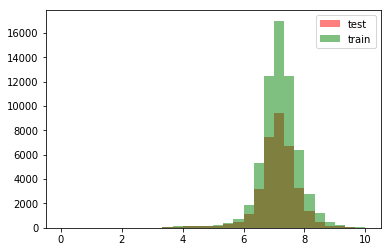

In [209]:
plt.hist(test_content['num_words_log'], bins=30, alpha=.5, color='red', label='test', range=(0,10));
plt.hist(train_content['num_words_log'], bins=30, alpha=.5, color='green', label='train', range=(0,10));
plt.legend();

In [210]:
scaler = StandardScaler()
scaler.fit(train_content['num_words_log'].values.reshape(-1,1))

train_content['num_words_log_scaled'] = scaler.transform(train_content['num_words_log'].values.reshape(-1,1))
test_content['num_words_log_scaled'] = scaler.transform(test_content['num_words_log'].values.reshape(-1,1))

**TFIDF FOR CONTENT**

In [211]:
gc.collect()

5917

In [212]:
%%time
with open(os.path.join(PATH_TO_DATA, 'X_train_content_sparse.pkl'), 'rb') as pickle_file:
          X_train_content_sparse = pickle.load(pickle_file)

with open(os.path.join(PATH_TO_DATA, 'X_test_content_sparse.pkl'), 'rb') as pickle_file:
          X_test_content_sparse = pickle.load(pickle_file)

CPU times: user 6.34 s, sys: 2.41 s, total: 8.75 s
Wall time: 8.73 s


In [213]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

***Tf-Idf with article titles***

In [214]:
train_title = pd.read_table(os.path.join(PATH_TO_DATA,'train_title.txt'), sep='\n', header=None)
test_title = pd.read_table(os.path.join(PATH_TO_DATA,'test_title.txt'), sep='\n', header=None)

In [215]:
train_title.shape, test_title.shape

((62313, 1), (34645, 1))

In [216]:
train_title.head()

,0
0,Medium Terms of Service – Medium Policy – Medium
1,Amendment to Medium Terms of Service Applicabl...
2,走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium
3,How fast can a camera get? – What comes to min...
4,A game for the lonely fox – What comes to mind...


In [217]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1,1), max_df=0.5, max_features=100000)
X_train_title_sparse = tfidf.fit_transform(train_title[0])

CPU times: user 1.29 s, sys: 140 µs, total: 1.29 s
Wall time: 1.29 s


In [218]:
%%time
X_test_title_sparse = tfidf.transform(test_title[0])

CPU times: user 548 ms, sys: 0 ns, total: 548 ms
Wall time: 546 ms


In [219]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 66032), (34645, 66032))

In [220]:
with open(os.path.join(PATH_TO_DATA, 'X_train_title_sparse.pkl'), 'wb') as X_train_pkl:
    pickle.dump(X_train_title_sparse, X_train_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_title_sparse.pkl'), 'wb') as X_test_pkl:
    pickle.dump(X_test_title_sparse, X_test_pkl, protocol=2)

***Bag of authors (i.e. One-Hot-Encoded author names)***

In [221]:
%%time
train_author = pd.read_table(os.path.join(PATH_TO_DATA,'train_author.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

test_author = pd.read_table(os.path.join(PATH_TO_DATA,'test_author.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.75 s


In [222]:
train_author.shape, test_author.shape

((62313, 1), (34645, 1))

In [223]:
train_author.head()

,0
0,"{'name': None, 'url': 'https://medium.com/@Med..."
1,"{'name': None, 'url': 'https://medium.com/@Med..."
2,"{'name': None, 'url': 'https://medium.com/@ael..."
3,"{'name': None, 'url': 'https://medium.com/@vai..."
4,"{'name': None, 'url': 'https://medium.com/@vai..."


In [224]:
%%time
train_author['twitter'] = train_author.iloc[:, 0].apply(lambda x: x.get('twitter'))
train_author['url'] = train_author.iloc[:, 0].apply(lambda x: x.get('url'))
train_author['name'] = train_author.iloc[:, 0].apply(lambda x: x.get('name'))

test_author['twitter'] = test_author.iloc[:, 0].apply(lambda x: x.get('twitter'))
test_author['url'] = test_author.iloc[:, 0].apply(lambda x: x.get('url'))
test_author['name'] = test_author.iloc[:, 0].apply(lambda x: x.get('name'))

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 109 ms


In [225]:
train_author['name'] = train_author['name'].map(str)
train_author['url'] = train_author['url'].map(str)
train_author['twitter'] = train_author['twitter'].map(str)

test_author['name'] = test_author['name'].map(str)
test_author['url'] = test_author['url'].map(str)
test_author['twitter'] = test_author['twitter'].map(str)

In [226]:
train_author.head()

,0,twitter,url,name
0,"{'name': None, 'url': 'https://medium.com/@Med...",@Medium,https://medium.com/@Medium,None
1,"{'name': None, 'url': 'https://medium.com/@Med...",@Medium,https://medium.com/@Medium,None
2,"{'name': None, 'url': 'https://medium.com/@ael...",@aelcenganda,https://medium.com/@aelcenganda,None
3,"{'name': None, 'url': 'https://medium.com/@vai...",@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None
4,"{'name': None, 'url': 'https://medium.com/@vai...",@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None


In [227]:
train_author.drop(0, axis=1, inplace=True)
test_author.drop(0, axis=1, inplace=True)

In [228]:
train_author.head()

,twitter,url,name
0,@Medium,https://medium.com/@Medium,None
1,@Medium,https://medium.com/@Medium,None
2,@aelcenganda,https://medium.com/@aelcenganda,None
3,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None
4,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe,None


In [229]:
len(set(train_author['twitter'].values))

23588

In [230]:
encoder = LabelBinarizer(sparse_output=True)
X_test_author_sparse = encoder.fit_transform(test_author['twitter'])

In [231]:
encoder.inverse_transform(X_test_author_sparse[6,:])

array(['None'],
      dtype='<U16')

In [232]:
X_train_author_sparse = encoder.transform(train_author['twitter'])

In [233]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 12199), (34645, 12199))

*** Time features***

In [296]:
train_published = pd.read_table(os.path.join(PATH_TO_DATA,'train_published.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

test_published = pd.read_table(os.path.join(PATH_TO_DATA,'test_published.txt'), sep='\n', header=None).\
                applymap(lambda x: eval(x))

In [297]:
train_published['published'] = train_published.iloc[:, 0].apply(lambda x: x.get('$date'))
train_published['published'] = train_published['published'].apply(pd.to_datetime).fillna(method='ffill')

test_published['published'] = test_published.iloc[:, 0].apply(lambda x: x.get('$date'))
test_published['published'] = test_published['published'].apply(pd.to_datetime).fillna(method='ffill')

In [298]:
train_published['year'] = train_published['published'].apply(lambda ts: ts.year)
train_published['month'] = train_published['published'].apply(lambda ts: ts.month)
train_published['weekday'] = train_published['published'].apply(lambda ts: ts.weekday())

test_published['year'] = test_published['published'].apply(lambda ts: ts.year)
test_published['month'] = test_published['published'].apply(lambda ts: ts.month)
test_published['weekday'] = test_published['published'].apply(lambda ts: ts.weekday())

In [299]:
train_published['year_month'] = train_published['year']*100 + train_published['month']
test_published['year_month'] = test_published['year']*100 + test_published['month']

In [300]:
train_published['year_month_wat'] = train_published['year_month']/100000
test_published['year_month_wat'] = test_published['year_month']/100000

In [301]:
scaler = StandardScaler()
scaler.fit(train_published['year_month'].values.reshape(-1,1))

train_published['year_month_scaled'] = scaler.transform(train_published['year_month'].values.reshape(-1,1))
test_published['year_month_scaled'] = scaler.transform(test_published['year_month'].values.reshape(-1,1))

/home/kcostya/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [302]:
test_published.head()

,0,published,year,month,weekday,year_month,year_month_wat,year_month_scaled
0,{'$date': '2018-02-21T17:01:00.928Z'},2018-02-21 17:01:00.928,2018,2,2,201802,2.01802,1.921747
1,{'$date': '2017-12-07T15:56:00.967Z'},2017-12-07 15:56:00.967,2017,12,3,201712,2.01712,1.056774
2,{'$date': '2018-02-08T17:33:27.816Z'},2018-02-08 17:33:27.816,2018,2,3,201802,2.01802,1.921747
3,{'$date': '2018-02-09T18:04:12.262Z'},2018-02-09 18:04:12.262,2018,2,4,201802,2.01802,1.921747
4,{'$date': '2017-10-02T23:08:00.000Z'},2017-10-02 23:08:00.000,2017,10,0,201710,2.01710,1.037553


In [303]:
train_published.drop([0,'published'], axis=1, inplace=True)
test_published.drop([0,'published'], axis=1, inplace=True)

In [304]:
train_published.head()

,year,month,weekday,year_month,year_month_wat,year_month_scaled
0,2012,8,0,201208,2.01208,-3.787076
1,2015,8,0,201508,2.01508,-0.903832
2,2017,2,6,201702,2.01702,0.960666
3,2017,5,5,201705,2.01705,0.989499
4,2017,6,6,201706,2.01706,0.999109


In [305]:
train_published['month'].value_counts()

5     6808
6     6730
3     6512
4     6189
1     5782
2     5598
12    4742
11    4537
10    4410
8     3798
9     3792
7     3415
Name: month, dtype: int64

In [306]:
X_train_time_features = pd.DataFrame(pd.concat([train_published['year_month_scaled'],train_published['year_month_wat'],
                                                pd.get_dummies(train_published['weekday'],
                                                               prefix='day', drop_first=False)], axis=1))

X_test_time_features = pd.DataFrame(pd.concat([test_published['year_month_scaled'], test_published['year_month_wat'],
                                                pd.get_dummies(test_published['weekday'],
                                                               prefix='day', drop_first=False)], axis=1))

In [307]:
X_train_time_features.columns

Index(['year_month_scaled', 'year_month_wat', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6'],
      dtype='object')

In [308]:
X_train_time_features.head()

,year_month_scaled,year_month_wat,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,-3.787076,2.01208,1,0,0,0,0,0,0
1,-0.903832,2.01508,1,0,0,0,0,0,0
2,0.960666,2.01702,0,0,0,0,0,0,1
3,0.989499,2.01705,0,0,0,0,0,1,0
4,0.999109,2.01706,0,0,0,0,0,0,1


In [309]:
X_train_time_features.drop(['year_month_scaled', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'], axis=1, inplace=True)

In [310]:
X_test_time_features.drop(['year_month_scaled','day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'], axis=1, inplace=True)

In [311]:
X_train_time_features.shape

(62313, 1)

**Join all sparse matrices.**

In [312]:
import gc
gc.collect()

618

In [313]:
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,X_train_author_sparse, 
                                    X_train_time_features, 
                                    train_content[['num_words_log_scaled']], 
                                    X_train_pics, X_train_time]))

In [314]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,X_test_author_sparse, 
                                   X_test_time_features,
                                   test_content[['num_words_log_scaled']], 
                                   X_test_pics, X_test_time]))

In [315]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 178361), (34645, 178361))

**Read train target and split data for validation.**

In [316]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA,'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [317]:
%%time
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sparse, y_train);

CPU times: user 1min 43s, sys: 1.37 s, total: 1min 44s
Wall time: 1min 44s


In [318]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

CPU times: user 144 ms, sys: 171 µs, total: 144 ms
Wall time: 143 ms


In [319]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA,'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [320]:
write_submission_file(ridge_test_pred, 'assignment6_medium_submission_Ridge_tuned.csv')

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [321]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [322]:
ridge_test_pred_modif = ridge_test_pred*(4.33328*ridge_test_pred.shape[0])/sum(ridge_test_pred)

In [323]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack_tuned.csv')